In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bmb


In [2]:

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez



Note that the test and train data have the same format except the test data doesn't have a transported column.   I am going to add a 'Train' column to make seperating these easier and then later join them up.

In [4]:
train_data['Train']= True
test_data['Train'] = False

all_data = pd.concat([train_data,test_data]).reset_index(drop=True)

## Examine and PreProcess data

Missing data?

In [5]:
all_data.apply(lambda x:np.sum(x.isna()))/all_data.count()

PassengerId     0.000000
HomePlanet      0.022709
CryoSleep       0.024487
Cabin           0.023597
Destination     0.021582
Age             0.021260
VIP             0.023355
RoomService     0.020697
FoodCourt       0.022790
ShoppingMall    0.024163
Spa             0.022387
VRDeck          0.021099
Name            0.023193
Transported     0.492005
Train           0.000000
dtype: float64

Each column has about 2% missing data.

In [6]:
def plot_transported_rate(data, col, plot_logodds = False):
    survival  = data[["Transported",col]].groupby(col).mean().reset_index()
    if plot_logodds:
        survival["Transported"] = survival["Transported"].apply(lambda x:np.log(x/(1-x)))
    sns.barplot(data=survival,x=col, y='Transported')

### Home Planet

<AxesSubplot:xlabel='HomePlanet', ylabel='Count'>

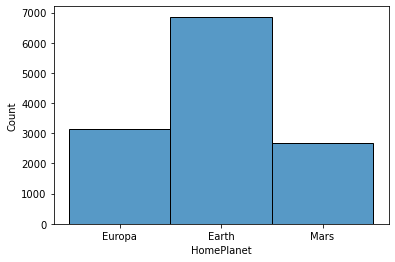

In [7]:
sns.histplot(all_data['HomePlanet'])

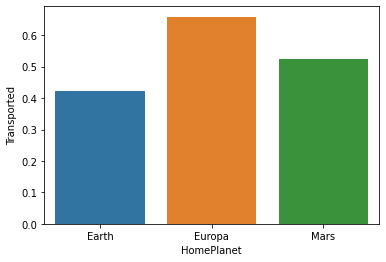

In [8]:
plot_transported_rate(all_data[all_data["Train"]], "HomePlanet")

Ok home planet is most commonly earth, so we will fill in Earth for missing ones. We also want to make this Categorical. 

In [9]:
all_data.loc[all_data.HomePlanet.isna(),"HomePlanet"] = "Earth"

In [10]:
all_data = all_data.join(pd.get_dummies(all_data["HomePlanet"], prefix="HP", drop_first=True)) # Earth is baseline

### Cryosleep

In [11]:
all_data['CryoSleep'] = all_data['CryoSleep'].astype('category') 

In [12]:
all_data['CryoSleep'].value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [13]:
all_data.loc[all_data["CryoSleep"].isna(),"CryoSleep"] = False 

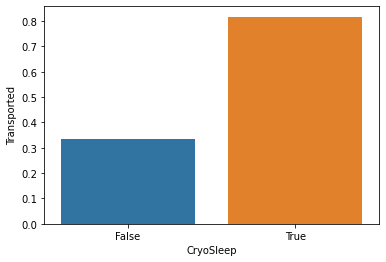

In [14]:
plot_transported_rate(all_data[all_data["Train"]], "CryoSleep")

Cryosleep is a STRONG predictor of being transported

### Cabin 

This one is a bit tricky as there is clearly useful information from this but we are going to have to parse it out abit. First look at all the non-na.  REMEMBER DO NOT combine these with the original data yet.

In [15]:
cabin_temp = all_data.loc[all_data.Cabin.notna(),["Cabin","Transported", "Train"]].reset_index(drop=True)

cabin_dat =pd.DataFrame(cabin_temp["Cabin"].map(lambda x: x.split('/')).to_list(), columns= ["Class","Number","PS"])

cabin_comb = cabin_temp.join(cabin_dat)
cabin_comb.head()

,Cabin,Transported,Train,Class,Number,PS
0,B/0/P,False,True,B,0,P
1,F/0/S,True,True,F,0,S
2,A/0/S,False,True,A,0,S
3,A/0/S,False,True,A,0,S
4,F/1/S,True,True,F,1,S


In [16]:
cabin_comb.apply(lambda x:np.sum(x.isna()))

Cabin             0
Transported    4177
Train             0
Class             0
Number            0
PS                0
dtype: int64

<AxesSubplot:xlabel='Class', ylabel='Count'>

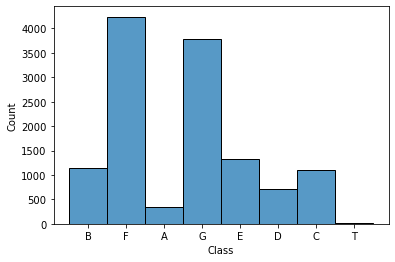

In [17]:
sns.histplot(cabin_comb["Class"])

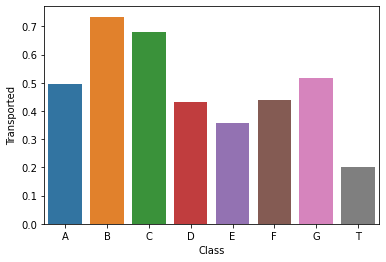

In [18]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]], "Class")

Class seems to effect transport rate

In [19]:
cabin_comb["PS"].describe()   #Port Starboard?

count     12671
unique        2
top           S
freq       6381
Name: PS, dtype: object

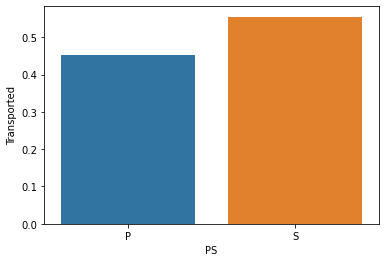

In [20]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]] , "PS")

Hmm.. port starboard might matter too!  Not sure how do deal with the missing values in this event.  Possibly add a third category = missing

In [21]:
cabin_comb["Number"].astype("int").describe()

count    12671.000000
mean       603.601926
std        512.891926
min          0.000000
25%        170.000000
50%        431.000000
75%       1008.000000
max       1894.000000
Name: Number, dtype: float64

In [22]:
cabin_comb["Number"] = cabin_comb["Number"].astype("int")

In [23]:
cabin_comb["Num_Cat"] = pd.qcut(cabin_comb["Number"],8)

In [24]:
cabin_comb.head()

,Cabin,Transported,Train,Class,Number,PS,Num_Cat
0,B/0/P,False,True,B,0,P,"(-0.001, 79.0]"
1,F/0/S,True,True,F,0,S,"(-0.001, 79.0]"
2,A/0/S,False,True,A,0,S,"(-0.001, 79.0]"
3,A/0/S,False,True,A,0,S,"(-0.001, 79.0]"
4,F/1/S,True,True,F,1,S,"(-0.001, 79.0]"


In [25]:
cabin_comb["Num_Cat"].value_counts()

(-0.001, 79.0]      1599
(170.0, 267.0]      1591
(682.75, 1008.0]    1588
(1338.0, 1894.0]    1583
(431.0, 682.75]     1582
(1008.0, 1338.0]    1581
(267.0, 431.0]      1574
(79.0, 170.0]       1573
Name: Num_Cat, dtype: int64

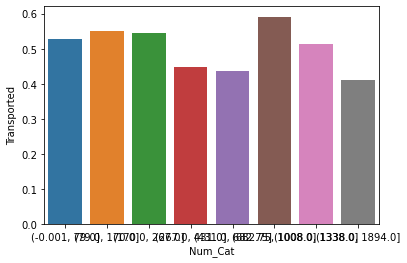

In [26]:
plot_transported_rate(cabin_comb[cabin_comb["Train"]], "Num_Cat")

Seems like the number matters... but for a first pass I will skip on it.  Ok so here is what we will do for this case: 

* Split out all the no-na values .  drop cabin number. 

* Set class = 'F" and PS = 'Uknown"  for na's

In [27]:
def get_class_ps(x):
    if pd.isna(x):
        return ['F','Unknown']
    else:
        (c,num,ps) = x.split('/')
        return [c,ps]

cabin_dat = pd.DataFrame(all_data["Cabin"].map(get_class_ps).to_list(), columns= ["Class","PS"])

 

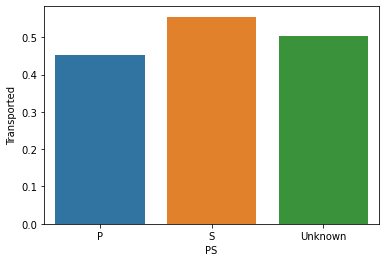

In [28]:
all_data = all_data.join(cabin_dat)
plot_transported_rate(all_data[all_data["Train"]] , "PS")

In [29]:
all_data["PS"].value_counts()

S          6381
P          6290
Unknown     299
Name: PS, dtype: int64

The 300 'Uknown" are probably not going to be worth much in training, but i will leave it this way. For the rest I will replace with mode or mean .

In [30]:
all_data = all_data.join(pd.get_dummies(all_data["PS"],prefix="SIDE", drop_first=True) )
all_data = all_data.join(pd.get_dummies(all_data["Class"], prefix="Class")).drop(columns="Class_F") #dropping most common class to use as base
all_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,PS,SIDE_S,SIDE_Unknown,Class_A,Class_B,Class_C,Class_D,Class_E,Class_G,Class_T
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,P,0,0,0,1,0,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,S,1,0,0,0,0,0,0,0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,S,1,0,1,0,0,0,0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,S,1,0,1,0,0,0,0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,S,1,0,0,0,0,0,0,0,0


In [31]:
all_data = all_data.drop(columns = ["HomePlanet","Cabin","Class","PS"])
all_data.head()

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,HP_Mars,SIDE_S,SIDE_Unknown,Class_A,Class_B,Class_C,Class_D,Class_E,Class_G,Class_T
0,0001_01,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0002_01,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,0,1,0,0,0,0,0,0,0,0
2,0003_01,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,0,1,0,1,0,0,0,0,0,0
3,0003_02,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,0,1,0,1,0,0,0,0,0,0
4,0004_01,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,0,1,0,0,0,0,0,0,0,0


Note that Class A is baseline, as is Port

### Destination

<AxesSubplot:xlabel='Destination', ylabel='Count'>

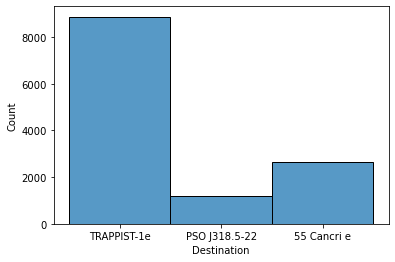

In [32]:
sns.histplot(all_data["Destination"])

In [33]:
all_data.loc[all_data["Destination"].isna(), "Destination"] = all_data["Destination"].mode()
all_data["Destination"] = all_data["Destination"].astype("category")

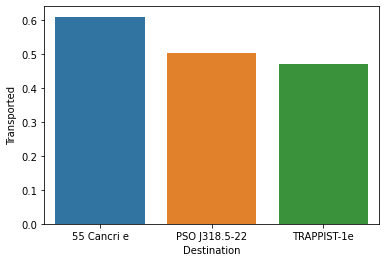

In [34]:
plot_transported_rate(all_data[all_data["Train"]] , "Destination")

In [35]:
all_data = all_data.join(pd.get_dummies(all_data["Destination"], prefix="Dest")).drop(columns = ["Destination",'Dest_TRAPPIST-1e'])
all_data.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,SIDE_Unknown,Class_A,Class_B,Class_C,Class_D,Class_E,Class_G,Class_T,Dest_55 Cancri e,Dest_PSO J318.5-22
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0,0,1,0,0,0,0,0,0,0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0,0,0,0,0,0,0,0,0,0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,...,0,1,0,0,0,0,0,0,0,0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,...,0,1,0,0,0,0,0,0,0,0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,...,0,0,0,0,0,0,0,0,0,0


TRAPPIST-1e is baseline here.

### Age

In [36]:
all_data.Age.describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [37]:
all_data.loc[all_data["Age"].isna(),"Age"] = np.mean(all_data.Age)

In [38]:
all_data["Age_Cat"]  = pd.cut(all_data["Age"],[0,12,21,30,60,100])

In [39]:
all_data["Age_Cat"].value_counts()

(30, 60]     4715
(21, 30]     3808
(12, 21]     2963
(0, 12]       897
(60, 100]     327
Name: Age_Cat, dtype: int64

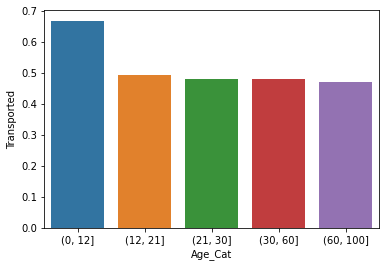

In [40]:
plot_transported_rate(all_data[all_data["Train"]] , "Age_Cat")

In [41]:
mean_age = all_data["Age"].mean()
std_age = all_data["Age"].std()
all_data["Age_Std"] = (all_data["Age"] - mean_age)/std_age
(mean_age,std_age)

(28.77196850393714, 14.236709921289403)

In [42]:
all_data = all_data.drop(columns=["Name", "Age","Age_Cat"])

### VIP

In [43]:
all_data.VIP.value_counts()

False    12401
True       273
Name: VIP, dtype: int64

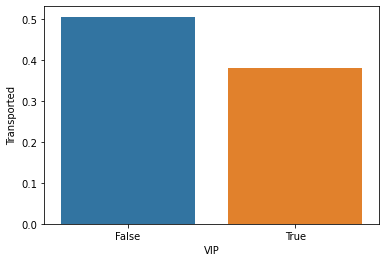

In [44]:
all_data.loc[all_data["VIP"].isna(),"VIP"] = False
plot_transported_rate(all_data[all_data["Train"]] , "VIP")

### Spending

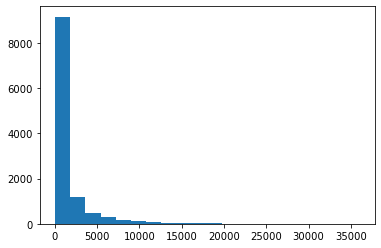

In [45]:
plt.hist(all_data["VRDeck"]+all_data["Spa"]+all_data["RoomService"]+all_data["ShoppingMall"]+all_data["FoodCourt"],bins=20);

In [46]:
spend = all_data.loc[:,"RoomService":"VRDeck"]
spend.mode()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0


Most commonof all these is zero spend

In [47]:
for x in spend.columns:
    all_data.loc[all_data[x].isna(),x] = 0.0

Ok lets see if any of these are useful in isolation

In [48]:
temp = all_data[spend.columns.append(pd.Index(['Transported','Train']))].reset_index(drop=True)
for x in spend.columns:
    temp[x + "_cut"] = pd.cut(temp[x],[-1,0,1000,2000,5000,10000,20000,40000])


In [49]:
temp.max()

RoomService                14327.0
FoodCourt                  29813.0
ShoppingMall               23492.0
Spa                        22408.0
VRDeck                     24133.0
Transported                   True
Train                         True
RoomService_cut     (10000, 20000]
FoodCourt_cut       (20000, 40000]
ShoppingMall_cut    (20000, 40000]
Spa_cut             (20000, 40000]
VRDeck_cut          (20000, 40000]
dtype: object

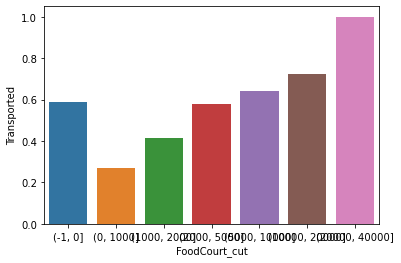

In [50]:
plot_transported_rate(temp[temp["Train"]] , "FoodCourt_cut")

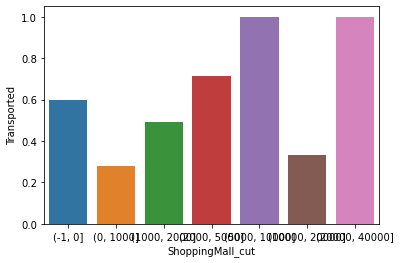

In [51]:
plot_transported_rate(temp[temp["Train"]] , "ShoppingMall_cut")

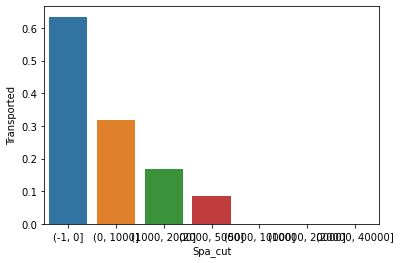

In [183]:
plot_transported_rate(temp[temp["Train"]] , "Spa_cut")

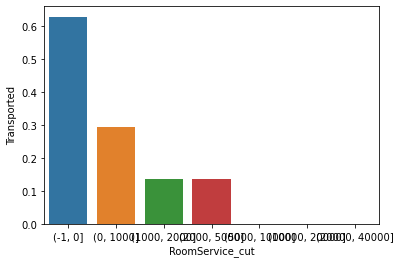

In [184]:
plot_transported_rate(temp[temp["Train"]] , "RoomService_cut")

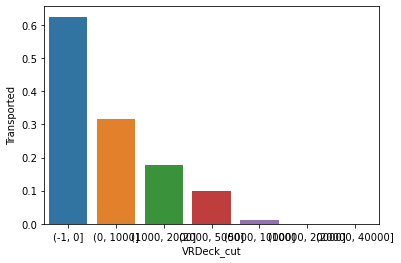

In [185]:
plot_transported_rate(temp[temp["Train"]] , "VRDeck_cut")

In [186]:
temp["VRDeck_cut"].value_counts()

(-1, 0]           8520
(0, 1000]         3525
(1000, 2000]       437
(2000, 5000]       323
(5000, 10000]      121
(10000, 20000]      41
(20000, 40000]       3
Name: VRDeck_cut, dtype: int64

In [187]:
temp["RoomService_cut"].value_counts()

(-1, 0]           8566
(0, 1000]         3488
(1000, 2000]       616
(2000, 5000]       264
(5000, 10000]       34
(10000, 20000]       2
(20000, 40000]       0
Name: RoomService_cut, dtype: int64

In [188]:
temp["Spa_cut"].value_counts()

(-1, 0]           8219
(0, 1000]         3818
(1000, 2000]       443
(2000, 5000]       344
(5000, 10000]      110
(10000, 20000]      35
(20000, 40000]       1
Name: Spa_cut, dtype: int64

For a first cut, I am going to only use the three luxury spending combined.  Not sure how well it will work with so many zeros.

In [52]:
all_data["LuxurySpend"] = all_data["Spa"] + all_data["VRDeck"] + all_data["RoomService"]

In [53]:
(all_data["LuxurySpend"].max(), all_data["LuxurySpend"].min())

(28600.0, 0.0)

In [54]:
cuts = list(range(-1000,30000,1000))
len(cuts)

31

In [55]:
all_data["LuxurySpend_cut"] = pd.cut(all_data["LuxurySpend"],cuts)

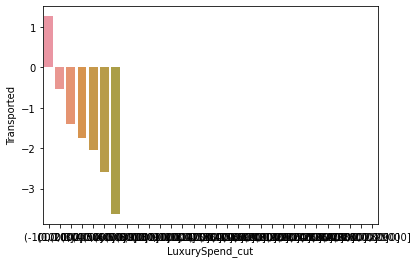

In [56]:
plot_transported_rate(all_data[all_data["Train"]] , "LuxurySpend_cut", plot_logodds=True)

In [57]:
all_data["LuxurySpend"].std()

1840.3056257046132

In [58]:
all_data["LuxurySpendK"] = all_data["LuxurySpend"]/1000.0

Try also log? But on the logodds scale, a straight linear looks best

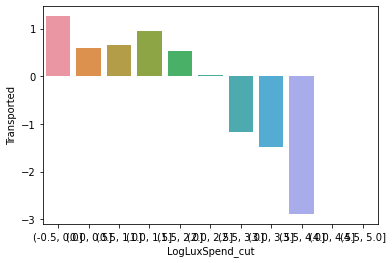

In [59]:
all_data["LogLuxSpend"] = np.log10(all_data["LuxurySpend"]+1)  
all_data["LogLuxSpend_cut"] = pd.cut(all_data["LogLuxSpend"],[-0.5,0,.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plot_transported_rate(all_data[all_data["Train"]] , "LogLuxSpend_cut",plot_logodds=True)

In [60]:
all_data.drop(columns=["RoomService", "FoodCourt", "ShoppingMall","Spa", "VRDeck","LogLuxSpend","LuxurySpend", "LuxurySpend_cut","LogLuxSpend_cut"], inplace=True)

Check we took care of all NA 's except of course in the test data

In [61]:
all_data.apply(lambda x:np.sum(x.isna()))

PassengerId              0
CryoSleep                0
VIP                      0
Transported           4277
Train                    0
HP_Europa                0
HP_Mars                  0
SIDE_S                   0
SIDE_Unknown             0
Class_A                  0
Class_B                  0
Class_C                  0
Class_D                  0
Class_E                  0
Class_G                  0
Class_T                  0
Dest_55 Cancri e         0
Dest_PSO J318.5-22       0
Age_Std                  0
LuxurySpendK             0
dtype: int64

### Re-devide data

In [62]:
# Now split it back out

test_data = all_data[~all_data["Train"]].drop(columns="Train").reset_index(drop=True)

train_data = all_data[all_data["Train"]].drop(columns="Train").reset_index(drop=True)


## Try to fit a logistic regression

In [201]:
predictors = train_data.drop(columns = [ "PassengerId", "Transported"]).columns.to_list()
predictors

['CryoSleep',
 'VIP',
 'HP_Europa',
 'HP_Mars',
 'SIDE_S',
 'SIDE_Unknown',
 'Class_A',
 'Class_B',
 'Class_C',
 'Class_D',
 'Class_E',
 'Class_G',
 'Class_T',
 'Dest_55 Cancri e',
 'Dest_PSO J318.5-22',
 'Age_Std',
 'LuxurySpendK']

In [206]:
COORDS = {"predictors": predictors}

with pm.Model(coords=COORDS) as m_full:
    a = pm.Normal("intercept", mu=0, sigma=3)
    b = pm.Normal("slopes", mu=0, sigma=5, dims="predictors")
     
    pred = pm.ConstantData("preds", train_data[predictors])

 
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu))


    y = pm.Bernoulli("y",p=p, observed=train_data["Transported"])

In [207]:
with m_full:
    idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 168 seconds.


In [208]:
az.summary(idata, var_names=['slopes','intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[CryoSleep],1.053,0.075,0.915,1.196,0.001,0.000,18875.0,15670.0,1.0
slopes[VIP],-0.087,0.231,-0.521,0.346,0.001,0.002,25137.0,14736.0,1.0
slopes[HP_Europa],2.101,0.205,1.708,2.476,0.002,0.001,13609.0,14499.0,1.0
slopes[HP_Mars],0.670,0.088,0.497,0.829,0.001,0.000,18447.0,15902.0,1.0
slopes[SIDE_S],0.558,0.056,0.450,0.660,0.000,0.000,22012.0,15255.0,1.0
slopes[SIDE_Unknown],-0.039,0.201,-0.418,0.332,0.001,0.001,23803.0,15043.0,1.0
slopes[Class_A],-0.821,0.280,-1.329,-0.274,0.002,0.002,15666.0,14221.0,1.0
slopes[Class_B],0.596,0.259,0.108,1.086,0.002,0.002,14984.0,15252.0,1.0
slopes[Class_C],1.898,0.275,1.369,2.399,0.002,0.002,15531.0,15579.0,1.0
slopes[Class_D],-0.038,0.163,-0.355,0.257,0.001,0.001,18083.0,15480.0,1.0


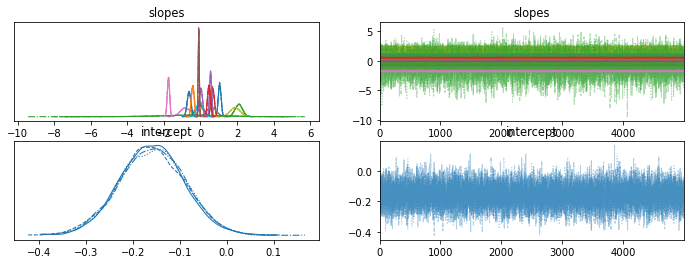

In [209]:
az.plot_trace(idata, var_names=['slopes','intercept']);

From the above it looks like VIP and Age are not very strong predictors so we will drop them as well as SIDE

In [212]:
predictors = train_data.drop(columns = [ "VIP", "Age_Std", "SIDE_S", "SIDE_Unknown", "PassengerId", "Transported"]).columns.to_list()
predictors

['CryoSleep',
 'HP_Europa',
 'HP_Mars',
 'Class_A',
 'Class_B',
 'Class_C',
 'Class_D',
 'Class_E',
 'Class_G',
 'Class_T',
 'Dest_55 Cancri e',
 'Dest_PSO J318.5-22',
 'LuxurySpendK']

In [213]:
COORDS = {"predictors": predictors}

with pm.Model(coords=COORDS) as m_2:
    a = pm.Normal("intercept", mu=0, sigma=3)
    b = pm.Normal("slopes", mu=0, sigma=5, dims="predictors")
     
    pred = pm.ConstantData("preds", train_data[predictors])

 
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu))


    y = pm.Bernoulli("y",p=p, observed=train_data["Transported"])

    idata2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 135 seconds.


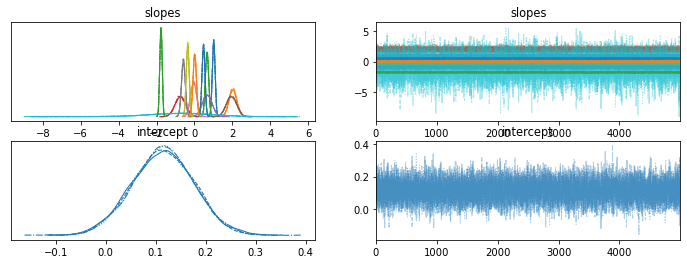

In [218]:

az.plot_trace(idata2, var_names=['slopes','intercept']);

In [219]:
az.summary(idata2, var_names=['slopes','intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[CryoSleep],1.014,0.073,0.877,1.153,0.001,0.000,16654.0,15341.0,1.0
slopes[HP_Europa],2.026,0.204,1.639,2.406,0.002,0.002,9098.0,12633.0,1.0
slopes[HP_Mars],0.660,0.087,0.499,0.825,0.001,0.000,15736.0,14964.0,1.0
slopes[Class_A],-0.749,0.274,-1.259,-0.231,0.003,0.002,11691.0,14409.0,1.0
slopes[Class_B],0.672,0.255,0.204,1.160,0.002,0.002,11159.0,13162.0,1.0
slopes[Class_C],1.951,0.271,1.452,2.463,0.003,0.002,11612.0,14121.0,1.0
slopes[Class_D],-0.048,0.161,-0.346,0.258,0.001,0.001,17503.0,16141.0,1.0
slopes[Class_E],-0.587,0.100,-0.773,-0.395,0.001,0.001,18012.0,16130.0,1.0
slopes[Class_G],-0.358,0.077,-0.499,-0.212,0.001,0.000,13799.0,14746.0,1.0
slopes[Class_T],-0.757,1.685,-3.987,2.369,0.011,0.012,23429.0,14115.0,1.0


Ok now just looking at only the MOST significant ones, especially for purposes of the BayesRules Homework

In [274]:
predictors =  ["CryoSleep","HP_Europa","HP_Mars","Dest_55 Cancri e","Dest_PSO J318.5-22","LuxurySpendK"]
train_data[predictors].head()

,CryoSleep,HP_Europa,HP_Mars,Dest_55 Cancri e,Dest_PSO J318.5-22,LuxurySpendK
0,False,1,0,0,0,0.000
1,False,0,0,0,0,0.702
2,False,1,0,0,0,6.807
3,False,1,0,0,0,3.522
4,False,0,0,0,0,0.870


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 98 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[CryoSleep],0.976,0.067,0.855,1.106,0.000,0.000,20440.0,15628.0,1.0
slopes[HP_Europa],2.691,0.108,2.484,2.889,0.001,0.001,20849.0,16132.0,1.0
slopes[HP_Mars],0.751,0.070,0.619,0.883,0.000,0.000,24226.0,16561.0,1.0
slopes[Dest_55 Cancri e],0.497,0.077,0.352,0.642,0.000,0.000,26891.0,15203.0,1.0
slopes[Dest_PSO J318.5-22],0.028,0.087,-0.133,0.194,0.001,0.001,23538.0,15896.0,1.0
slopes[LuxurySpendK],-1.635,0.059,-1.744,-1.525,0.000,0.000,17721.0,16235.0,1.0
intercept,-0.154,0.048,-0.245,-0.064,0.000,0.000,18176.0,14624.0,1.0


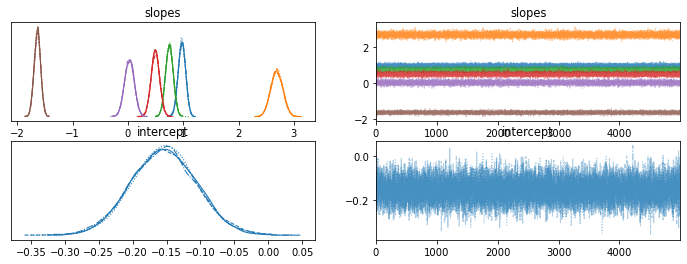

In [275]:
COORDS = {"predictors": predictors}

with pm.Model(coords=COORDS) as m_3:
    a = pm.Normal("intercept", mu=0, sigma=3)
    b = pm.Normal("slopes", mu=0, sigma=5, dims="predictors")
    
    # allow changing for predictions on new
    pred = pm.MutableData("preds", train_data[predictors])

    observed = pm.ConstantData("transported_obs", train_data["Transported"])
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu))


    y = pm.Bernoulli("y",p=p, observed=observed)

    idata3 = pm.sample(5000)

az.plot_trace(idata3, var_names=['slopes','intercept']);
az.summary(idata3, var_names=['slopes','intercept'])

In [276]:
with m_3:
    pm.sample_posterior_predictive(idata3, extend_inferencedata=True)
 

In [277]:
def compute_accuracy(id):
    (x,y,z) = id.posterior_predictive.y.values.shape
    pred = np.mean(id.posterior_predictive.y.values.reshape(x*y,-1) ,axis=0)>0.5
    return np.mean(pred == id.observed_data.y.values)

In [278]:
compute_accuracy(idata3)

0.7699298285977223

In [283]:
pred = np.mean(idata3.posterior_predictive.y.values.reshape(20000,-1) ,axis=0)>0.5
confusion = pd.DataFrame({'train' : train_data['Transported'], 'pred' : pred})
confusion['Count' ] =1
confusion.groupby(["train","pred"]).count().unstack()

Count      
pred  False  True
train            
False  3440   875
True   1125  3253

<AxesSubplot:ylabel='Count'>

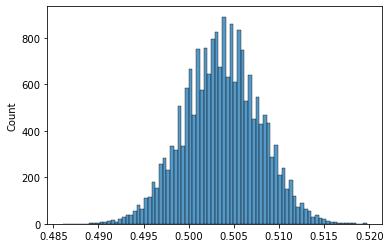

In [292]:
sns.histplot(np.mean(idata3.posterior_predictive.y.values.reshape(-1,20000) ,axis=0))

In [290]:
np.mean(train_data['Transported'])

0.5036236051995858

Posterior predictions looks good

In [387]:
with m_full:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

pred = np.mean(idata.posterior_predictive.y.values.reshape(20000,-1) ,axis=0)>0.5
confusion = pd.DataFrame({'train' : train_data['Transported'], 'pred' : pred})
confusion['Count' ] =1
confusion.groupby(["train","pred"]).count().unstack()

Count      
pred  False  True
train            
False  3353   962
True    957  3421

So "full model" doesnt do any better then my simpler one really (we dont need cross validation, if it doesnt do better on TRAIN data then we are done with it! If it did better, we would need to cross validate to make sure we are not over fitting)

Ok attempt some cross validation on model 3 just to see if it does as well

In [81]:
def train_and_test(predictors, train_data, test_data):
    COORDS = {"predictors": predictors}

    with pm.Model(coords=COORDS) as m_3:
       a = pm.Normal("intercept", mu=0, sigma=3)
       b = pm.Normal("slopes", mu=0, sigma=5, dims="predictors")
    
       # allow changing for predictions on new
       pred = pm.MutableData("preds", train_data[predictors])

       observed = pm.ConstantData("transported_obs", train_data["Transported"])
       mu = a + pm.math.matrix_dot(pred, b)
    
       p= pm.Deterministic("p", pm.math.invlogit(mu))


       y = pm.Bernoulli("y",p=p, observed=observed)

       id = pm.sample(5000)
       pm.set_data({"preds":test_data[predictors]})
       y_test = pm.sample_posterior_predictive(id)
       (x,y,z) = y_test.posterior_predictive.y.values.shape
       pred = np.mean(y_test.posterior_predictive.y.values.reshape(x*y,-1) ,axis=0)>0.5
       return np.mean(pred == test_data['Transported'])
       
 

In [259]:
train_and_test(predictors, train_data, train_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 111 seconds.


0.7702749338548257

In [260]:
len(train_data)/10

869.3

In [83]:
fold_labels = np.repeat([1,2,3,4,5,6,7,8,9,10],879)
np.random.shuffle(fold_labels)
fold_labels = fold_labels[:len(train_data)]
train_data["fold"] = fold_labels

In [ ]:

acc_cv = [train_and_test(predictors,train_data[train_data["fold"] != i], train_data[train_data["fold"] == i]) for i in range(1,11)]

In [266]:
np.mean(acc_cv)

0.7697111474869426

 What about JUST cryosleep and luxury spend? seems to do as well on test. CryoSleep didnt do as well. .

In [ ]:
predictors =  ["CryoSleep", "LuxurySpendK"]


In [270]:
predictors

['CryoSleep', 'LuxurySpendK']

In [ ]:
acc_cv = [train_and_test(predictors,train_data[train_data["fold"] != i], train_data[train_data["fold"] == i]) for i in range(1,11)]

In [273]:
np.mean(acc_cv)

0.7688023647503587

Just Luxury Spend? Maybe that is all that is needed? Nope not as good i think.

In [ ]:
predictors = ["LuxurySpendK"]

COORDS = {"predictors": predictors}

with pm.Model(coords=COORDS) as m_Lux:
    a = pm.Normal("intercept", mu=0, sigma=3)
    b = pm.Normal("slopes", mu=0, sigma=5, dims='predictors')
    
    # allow changing for predictions on new
    pred = pm.MutableData("preds", train_data[predictors])

    observed = pm.ConstantData("transported_obs", train_data["Transported"])
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu))


    y = pm.Bernoulli("y",p=p, observed=observed)

    idataLux = pm.sample(5000)

In [95]:
with m_Lux:
    pm.sample_posterior_predictive(idataLux, extend_inferencedata=True)

pred = np.mean(idataLux.posterior_predictive.y.values.reshape(20000,-1) ,axis=0)>0.5
confusion = pd.DataFrame({'train' : train_data['Transported'], 'pred' : pred})
confusion['Count' ] =1
confusion.groupby(["train","pred"]).count().unstack()

Count      
pred  False  True
train            
False  2794  1521
True    592  3786

In [96]:
(2794+3786)/len(train_data)

0.7569308639134936

## Try an interaction (Note this is not on the test data!)

Interactions tested:
-   CryoSleep:LuxurySpendK is not going to work since NO one who spent on luxury items was in cryosleep (obvious in hindsite!)
-   CryoSleep:HP_* : These did seem signficant! 
-   CryoSleep: Dest:  Significant but not hugely. 

Model 4 will add just CryoSleep:HP_*

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 117 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[CryoSleep],0.697,0.073,0.559,0.835,0.001,0.000,18033.0,16028.0,1.0
slopes[HP_Europa],2.412,0.116,2.192,2.629,0.001,0.001,22241.0,16408.0,1.0
slopes[HP_Mars],0.353,0.086,0.190,0.514,0.001,0.000,19727.0,15713.0,1.0
slopes[Dest_55 Cancri e],0.494,0.077,0.355,0.645,0.000,0.000,28511.0,15840.0,1.0
slopes[Dest_PSO J318.5-22],0.103,0.087,-0.059,0.269,0.001,0.000,27907.0,16305.0,1.0
slopes[LuxurySpendK],-1.547,0.059,-1.658,-1.438,0.000,0.000,18738.0,16229.0,1.0
slopes[CryoSleep:HP_Europa],1.324,0.350,0.679,1.993,0.002,0.002,24835.0,15538.0,1.0
slopes[CryoSleep:HP_Mars],1.340,0.173,1.018,1.665,0.001,0.001,20969.0,15339.0,1.0
intercept,-0.097,0.048,-0.187,-0.008,0.000,0.000,15674.0,15936.0,1.0


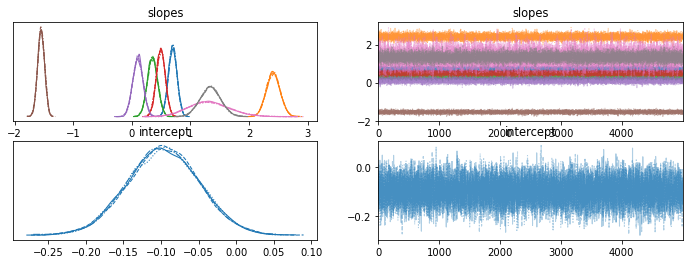

In [79]:
train_data["CryoSleep:HP_Europa"] = train_data["CryoSleep"].astype("int")*train_data["HP_Europa"]
train_data["CryoSleep:HP_Mars"] = train_data["CryoSleep"].astype("int")*train_data["HP_Mars"]
predictors =  ["CryoSleep","HP_Europa","HP_Mars","Dest_55 Cancri e","Dest_PSO J318.5-22","LuxurySpendK","CryoSleep:HP_Europa","CryoSleep:HP_Mars"]

COORDS = {"predictors": predictors}

with pm.Model(coords=COORDS) as m_4:
    a = pm.Normal("intercept", mu=0, sigma=3)
    b = pm.Normal("slopes", mu=0, sigma=5, dims="predictors")
    
    # allow changing for predictions on new
    pred = pm.MutableData("preds", train_data[predictors])

    observed = pm.ConstantData("transported_obs", train_data["Transported"])
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu))


    y = pm.Bernoulli("y",p=p, observed=observed)

    idata4 = pm.sample(5000)

az.plot_trace(idata4, var_names=['slopes','intercept']);
az.summary(idata4, var_names=['slopes','intercept'])

In [86]:
with m_4:
    pm.sample_posterior_predictive(idata4, extend_inferencedata=True)

pred = np.mean(idata4.posterior_predictive.y.values.reshape(20000,-1) ,axis=0)>0.5
confusion = pd.DataFrame({'train' : train_data['Transported'], 'pred' : pred})
confusion['Count' ] =1
confusion.groupby(["train","pred"]).count().unstack()

Count      
pred  False  True
train            
False  3451   864
True   1137  3241

In [87]:
(3451+3241)/len(train_data)

0.7698147935120212

Even though the predictors are significant they dont have enough effect to push teh prediction. However when we look at ROC curves this will be different no doubt!

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 122 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slopes[CryoSleep],0.969,0.076,0.827,1.113,0.001,0.000,14730.0,15124.0,1.0
slopes[HP_Europa],2.691,0.107,2.495,2.894,0.001,0.001,20651.0,16246.0,1.0
slopes[HP_Mars],0.746,0.071,0.613,0.877,0.000,0.000,21965.0,14840.0,1.0
slopes[Dest_55 Cancri e],0.427,0.088,0.269,0.598,0.001,0.000,20760.0,16235.0,1.0
slopes[Dest_PSO J318.5-22],0.124,0.119,-0.098,0.348,0.001,0.001,16461.0,15376.0,1.0
slopes[LuxurySpendK],-1.627,0.058,-1.737,-1.520,0.000,0.000,16308.0,15511.0,1.0
slopes[CryoSleep:Dest_55],0.294,0.182,-0.049,0.636,0.001,0.001,19753.0,15646.0,1.0
slopes[CryoSleep:Dest_PS],-0.190,0.173,-0.516,0.129,0.001,0.001,15874.0,15296.0,1.0
intercept,-0.153,0.049,-0.245,-0.060,0.000,0.000,14433.0,13264.0,1.0


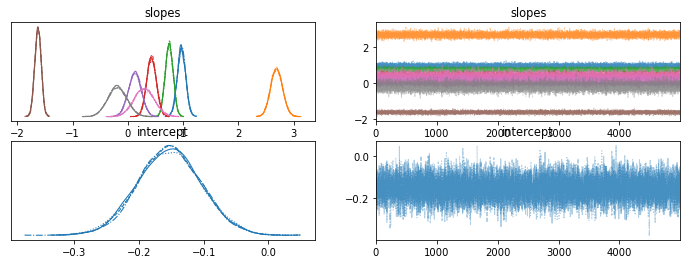

In [76]:
train_data["CryoSleep:Dest_55"] = train_data["CryoSleep"].astype("int")*train_data["Dest_55 Cancri e"]
train_data["CryoSleep:Dest_PS"] = train_data["CryoSleep"].astype("int")*train_data["Dest_PSO J318.5-22"]
predictors =  ["CryoSleep","HP_Europa","HP_Mars","Dest_55 Cancri e","Dest_PSO J318.5-22","LuxurySpendK","CryoSleep:Dest_55","CryoSleep:Dest_PS"]

COORDS = {"predictors": predictors}

with pm.Model(coords=COORDS) as m_temp:
    a = pm.Normal("intercept", mu=0, sigma=3)
    b = pm.Normal("slopes", mu=0, sigma=5, dims="predictors")
    
    # allow changing for predictions on new
    pred = pm.MutableData("preds", train_data[predictors])

    observed = pm.ConstantData("transported_obs", train_data["Transported"])
    mu = a + pm.math.matrix_dot(pred, b)
    
    p= pm.Deterministic("p", pm.math.invlogit(mu))


    y = pm.Bernoulli("y",p=p, observed=observed)

    idata_temp = pm.sample(5000)

az.plot_trace(idata_temp, var_names=['slopes','intercept']);
az.summary(idata_temp, var_names=['slopes','intercept'])

Cv on model 4

In [ ]:
predictors =  ["CryoSleep","HP_Europa","HP_Mars","Dest_55 Cancri e","Dest_PSO J318.5-22","LuxurySpendK","CryoSleep:HP_Europa","CryoSleep:HP_Mars"]
acc_cv = [train_and_test(predictors,train_data[train_data["fold"] != i], train_data[train_data["fold"] == i]) for i in range(1,11)]


In [85]:
(np.mean(acc_cv), np.std(acc_cv))

(0.7697954610512141, 0.012914388886005925)

## Bayres rules problems  (Use model 3)

# TODO

 

* Follow Bayes Rules exercise outline

* Try some interactions!

* Run prediction on test data and submit